<a href="https://colab.research.google.com/github/UniVR-DH/ADHLab/blob/main/lecture06-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Searching with Ngrams and Entities

We will use the Spacy Library:
https://spacy.io/usage/spacy-101


<img src="https://drive.google.com/uc?export=view&id=1m_EMdnI5C826kgqK7r5vB4TXnB0-Wq7W" alt="Intestazione con loghi istituzionali" width="525"/>

| Docente      | Insegnamento | Anno Accademico    |
| :---        |    :----   |          ---: |
| Matteo Lissandrini      | Laboratorio Avanzato di Informatica Umanistica       | 2023/2024   |

The content of this notebooks is heavily based on this conversation with ChatGPT

https://chat.openai.com/share/8dd2550f-8da7-49a8-b1c6-57d88fc9076c


## Usual install and basic imports

In [4]:
%pip install wikipedia-api
%pip install spacy==3.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.0 which is incompatible.


In [5]:
import wikipediaapi
import re

# Step 1: Import necessary libraries
#wiki_wiki = wikipediaapi.Wikipedia('en', user_agent='YourUserAgent/1.0')  # WRONG
# wiki_wiki = wikipediaapi.Wikipedia('en', extract_format=wikipediaapi.ExtractFormat.WIKI, user_agent='YourUserAgent/1.0') # WRONG
wiki_wiki = wikipediaapi.Wikipedia('MyTestProjectName (my.name@univr.it)',
                                   'en',
                                   extract_format=wikipediaapi.ExtractFormat.WIKI)

# Step 2: Prepare a list of titles of Wikipedia pages
fantasy_literature_titles = [
    "Fantasy literature",
    "The Lord of the Rings",
    "Harry Potter",
    "A Song of Ice and Fire",
    "The Chronicles of Narnia",
    "The Hobbit",
    "Alice's Adventures in Wonderland",
    "The Wizard of Oz",
    "The Silmarillion",
    "Discworld",
    "His Dark Materials",
    "The Wheel of Time",
    "Earthsea",
    "The Once and Future King",
    "The Princess Bride",
    "The Name of the Wind",
    "Mistborn",
    "The Malazan Book of the Fallen",
    "The Kingkiller Chronicle",
    "The Inheritance Cycle"
]

# Step 3: Write code to download main content in plain text and create a collection of cleaned text
cleaned_texts = []

for title in fantasy_literature_titles:
    page_py = wiki_wiki.page(title)

    if page_py.exists():
        # Keep the original URL of the page
        original_url = page_py.fullurl

        # Remove brackets and their contents from the text
        content = re.sub(r'\[[^\]]*\]', '', page_py.text)

        # Remove newline characters and extra spaces
        clean_text = ' '.join(content.split())

        # Store the cleaned text along with the original URL
        cleaned_texts.append({'title': title, 'content': clean_text, 'url': original_url})
    else:
        print(f"Page '{title}' does not exist on Wikipedia.")

# Display the cleaned texts and their original URLs (optional)
# for idx, entry in enumerate(cleaned_texts, 1):
#     print(f"Text {idx} - Title: {entry['title']}\nURL: {entry['url']}\nContent:\n{entry['content']}\n{'='*50}\n")


In [6]:
from collections import defaultdict
import re

# Step 4: Build an inverted index of lowercase ngrams ignoring non-alphanumeric symbols
inverted_index = defaultdict(list)

NGRAM_SIZE = 5

for entry in cleaned_texts:
    title = entry['title']
    content = entry['content'].lower()
    url = entry['url']

    # Remove non-alphanumeric symbols
    content = re.sub(r'[^a-z0-9 ]', '', content)

    # Generate ngrams of size NGRAM_SIZE
    ngrams = [content[i:i+NGRAM_SIZE] for i in range(len(content)-(NGRAM_SIZE-1))]

    # Build inverted index
    for trigram in set(ngrams):  # Using set to remove duplicates
        inverted_index[trigram].append({'title': title, 'url': url})

# Display the inverted index (optional)
# for ngram, entries in inverted_index.items():
#     print(f"N-gram: {ngram}")
#     for entry in entries:
#         print(f"  Title: {entry['title']}, URL: {entry['url']}")


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf(query, inverted_index, cleaned_texts):
    # Step 5: Given an input query, compute the TF-IDF for each page that matches at least one ngram
    query = query.lower()

    # Remove non-alphanumeric symbols
    query = re.sub(r'[^a-z0-9 ]', '', query)

    # Generate ngrams
    query_ngrams = [query[i:i+NGRAM_SIZE] for i in range(len(query)-(NGRAM_SIZE-1))]

    # Find matching trigrams in the inverted index
    matching_ngrams = set(query_ngrams).intersection(inverted_index.keys())

    # Collect titles and URLs of pages matching the trigrams
    matching_pages = []
    for ngram in matching_ngrams:
        matching_pages.extend(inverted_index[ngram])

    # Get unique titles and URLs
    unique_titles = list({page['title'] for page in matching_pages})
    unique_urls = list({page['url'] for page in matching_pages})

    # Extract content for the matching pages
    matching_contents = [entry['content'] for entry in cleaned_texts if entry['title'] in unique_titles]

    # Compute TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(matching_contents)

    # Get feature names (words) from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Prepare a list of pairs with URL and TF-IDF score for each matching page
    result_list = []
    for i, title in enumerate(unique_titles):
        tfidf_values = tfidf_matrix[i].toarray()[0]
        page_tfidf = {feature_names[j]: tfidf_values[j] for j in range(len(feature_names))}
        result_list.append({'url': unique_urls[i], 'tfidf_score': page_tfidf})

    return result_list

# Example usage:
query = "fantasy adventure"
result = compute_tfidf(query, inverted_index, cleaned_texts)
print(len(result))


20


In [8]:
# Function to print the top-k URLs and their TF-IDF scores
def print_top_k_urls(result_list, k):
    # Sort the result list based on the sum of TF-IDF scores
    sorted_results = sorted(result_list, key=lambda x: sum(x['tfidf_score'].values()), reverse=True)

    # Print the top-k URLs and their TF-IDF scores
    for i in range(min(k, len(sorted_results))):
        url = sorted_results[i]['url']
        tfidf_value = sum(sorted_results[i]['tfidf_score'].values())
        print(f"Top {i+1} URL: {url}, TF-IDF Value: {tfidf_value}")

# Example usage:
query = "fantasy adventure"
k = 5  # Change k to the desired number of top URLs
result = compute_tfidf(query, inverted_index, cleaned_texts)
print_top_k_urls(result, k)


Top 1 URL: https://en.wikipedia.org/wiki/The_Name_of_the_Wind, TF-IDF Value: 15.266600695829172
Top 2 URL: https://en.wikipedia.org/wiki/Discworld, TF-IDF Value: 14.107094592697385
Top 3 URL: https://en.wikipedia.org/wiki/The_Lord_of_the_Rings, TF-IDF Value: 13.80408119729509
Top 4 URL: https://en.wikipedia.org/wiki/Fantasy_literature, TF-IDF Value: 13.661325773324807
Top 5 URL: https://en.wikipedia.org/wiki/Malazan_Book_of_the_Fallen, TF-IDF Value: 13.65790134661919


In [9]:
%pip install spacy
%pip install networkx

In [20]:
import spacy
import networkx as nx

# Load SpaCy model for NER
nlp = spacy.load("en_core_web_sm")

# Function to extract entities from text using SpaCy NER, considering a minimum count
def extract_entities(text, min_entity_count=5):
    doc = nlp(text)
    entity_counts = Counter(ent.text.lower() for ent in doc.ents)
    entities = {ent.text: ent.label_ for ent in doc.ents if entity_counts[ent.text.lower()] >= min_entity_count}
    return entities


# Function to build a co-occurrence graph of entities with NetworkX
def build_co_occurrence_graph(cleaned_texts):
    co_occurrence_graph = nx.Graph()

    for entry in cleaned_texts:
        entities = extract_entities(entry['content'])
        for entity, label in entities.items():
            co_occurrence_graph.add_node(entity, label=label)
        for entity1, label1 in entities.items():
            for entity2, label2 in entities.items():
                if entity1 != entity2:
                    if co_occurrence_graph.has_edge(entity1, entity2):
                        co_occurrence_graph[entity1][entity2]['weight'] += 1
                    else:
                        co_occurrence_graph.add_edge(entity1, entity2, weight=1)

    return co_occurrence_graph

# Example usage:
co_occurrence_graph = build_co_occurrence_graph(cleaned_texts)

# Print the nodes, labels, edges, and weights in the co-occurrence graph
#for node, data in co_occurrence_graph.nodes(data=True):
#    print(f"Node: {node}, Label: {data['label']}")
#for edge in co_occurrence_graph.edges(data=True):
#    print(f"Edge: {edge[0]} - {edge[1]}, Weight: {edge[2]['weight']}")


In [21]:
import random

# Function to show the neighbors of a random node in the co-occurrence graph
def show_random_node_neighbors(co_occurrence_graph):
    # Get a random node from the graph
    random_node = random.choice(list(co_occurrence_graph.nodes()))

    # Get neighbors of the random node
    neighbors = list(co_occurrence_graph.neighbors(random_node))

    # Print the random node and its neighbors
    print(f"Random Node: {random_node}, Label: {co_occurrence_graph.nodes[random_node]['label']}")
    print(f"Neighbors: {neighbors}")

# Example usage:
show_random_node_neighbors(co_occurrence_graph)


Random Node: The Lord of the Rings, Label: WORK_OF_ART
Neighbors: ['Rings', 'English', 'Tolkien', 'The Hobbit', 'One', 'Middle-earth', 'Pippin', 'Boromir', 'Sauron', 'Frodo', 'one', 'two', 'Silmarillion', 'three', 'BBC', 'Gollum', 'Bilbo', 'Gandalf', 'Merry', 'Sam', 'Saruman', 'Mordor', 'Galadriel', 'Gimli', 'Legolas', 'Rohan', 'Minas Tirith', 'Gondor', 'First', 'first', 'the 1960s', 'the United States', 'Houghton Mifflin', '978']


In [22]:
# Function to compute PageRank scores for each node in the graph
def compute_page_rank(graph):
    page_rank_scores = nx.pagerank(graph)
    return page_rank_scores

# Example usage:
# co_occurrence_graph = build_co_occurrence_graph(cleaned_texts)  # Assuming `build_co_occurrence_graph` is defined
page_rank_scores = compute_page_rank(co_occurrence_graph)

# Print the top-k nodes with the highest PageRank scores
k = 5  # Change k to the desired number of top nodes
top_nodes = sorted(page_rank_scores, key=page_rank_scores.get, reverse=True)[:k]

for node in top_nodes:
    label = co_occurrence_graph.nodes[node]['label']
    page_rank = page_rank_scores[node]
    print(f"Node: {node}, Label: {label}, PageRank Score: {page_rank}")

Node: first, Label: ORDINAL, PageRank Score: 0.02948451296297414
Node: one, Label: CARDINAL, PageRank Score: 0.022973013483891067
Node: two, Label: CARDINAL, PageRank Score: 0.02022754705391083
Node: second, Label: ORDINAL, PageRank Score: 0.019385566605250478
Node: three, Label: CARDINAL, PageRank Score: 0.01727790639888287


In [23]:
# Print the top-k nodes of type 'PERSON' with the highest PageRank scores
k = 5  # Change k to the desired number of top nodes
person_nodes = [node for node in page_rank_scores if co_occurrence_graph.nodes[node]['label'] == 'PERSON']
top_person_nodes = sorted(person_nodes, key=page_rank_scores.get, reverse=True)[:k]

for node in top_person_nodes:
    label = co_occurrence_graph.nodes[node]['label']
    page_rank = page_rank_scores[node]
    print(f"Node: {node}, Label: {label}, PageRank Score: {page_rank}")

Node: Tolkien, Label: PERSON, PageRank Score: 0.011165033657602335
Node: Houghton Mifflin, Label: PERSON, PageRank Score: 0.006632282362434322
Node: Gollum, Label: PERSON, PageRank Score: 0.004031559968788694
Node: Bilbo, Label: PERSON, PageRank Score: 0.004031559968788694
Node: Sanderson, Label: PERSON, PageRank Score: 0.003954766879490537


In [24]:
# Function to build an inverted index of entities with corresponding pages
def build_entity_inverted_index(cleaned_texts):
    inverted_index = {}

    for entry in cleaned_texts:
        entities = extract_entities(entry['content'])
        for entity, label in entities.items():
            if entity not in inverted_index:
                inverted_index[entity] = {'label': label, 'pages': []}
            inverted_index[entity]['pages'].append({'title': entry['title'], 'url': entry['url']})

    return inverted_index

# Example usage:
entity_inverted_index = build_entity_inverted_index(cleaned_texts)

print(len(entity_inverted_index))

# Print the inverted index (optional)
#for entity, data in entity_inverted_index.items():
#    print(f"Entity: {entity}, Label: {data['label']}")
#    for page in data['pages']:
#        print(f"  Page Title: {page['title']}, URL: {page['url']}")


286


In [25]:
import networkx as nx
from collections import Counter

# Function to build a graph with nodes as pages and edges between pages sharing some entity mentions
def build_page_graph(cleaned_texts, max_entity_percentage=0.85):
    page_graph = nx.Graph()

    # Build an inverted index of entities with corresponding pages
    entity_inverted_index = build_entity_inverted_index(cleaned_texts)

    # Count entity occurrences in each page
    entity_counts = Counter()
    for data in entity_inverted_index.values():
        for page in data['pages']:
            entity_counts[page['title']] += 1

    # Identify entities that appear in more than max_entity_percentage of pages
    frequent_entities = {entity for entity, data in entity_inverted_index.items() if len(data['pages']) > max_entity_percentage * len(cleaned_texts)}

    # Add nodes to the graph (representing pages) without frequent entities
    for entry in cleaned_texts:
        if entry['title'] not in frequent_entities:
            page_graph.add_node(entry['title'], label='Page', url=entry['url'])

    # Add edges between pages that share some entity mentions, excluding frequent entities
    for entity, data in entity_inverted_index.items():
        if len(data['pages']) > 1 and entity not in frequent_entities:
            for i in range(len(data['pages'])):
                for j in range(i + 1, len(data['pages'])):
                    page1 = data['pages'][i]['title']
                    page2 = data['pages'][j]['title']
                    if not page_graph.has_edge(page1, page2):
                        page_graph.add_edge(page1, page2, entities=[entity])

    return page_graph

# Example usage:
page_graph = build_page_graph(cleaned_texts)

In [26]:
# Print the number of nodes, edges, and average degree
num_nodes = page_graph.number_of_nodes()
num_edges = page_graph.number_of_edges()
avg_degree = sum(dict(page_graph.degree()).values()) / num_nodes

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Average Degree: {avg_degree}")



Number of Nodes: 20
Number of Edges: 116
Average Degree: 11.6


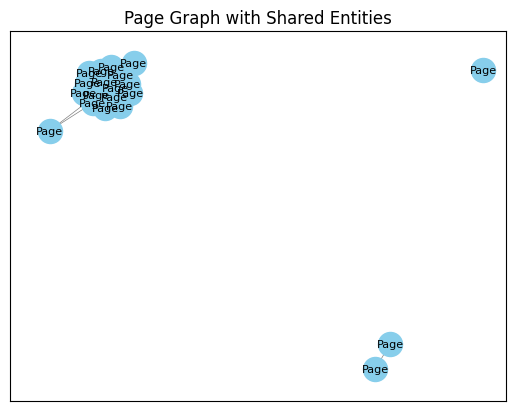

In [27]:
import matplotlib.pyplot as plt

# Function to plot the page graph
def plot_page_graph(page_graph):
    pos = nx.spring_layout(page_graph)  # You can use other layout algorithms as well

    # Draw nodes
    nx.draw_networkx_nodes(page_graph, pos, node_color='skyblue', node_size=300)

    # Draw edges
    nx.draw_networkx_edges(page_graph, pos, edge_color='gray', width=0.5)

    # Draw labels
    labels = nx.get_node_attributes(page_graph, 'label')
    nx.draw_networkx_labels(page_graph, pos, labels, font_size=8, font_color='black')

    plt.title('Page Graph with Shared Entities')
    plt.show()

# Example usage:
plot_page_graph(page_graph)
